In [36]:
import duckdb
import matplotlib.pyplot as plt
from matplotlib.scale import LogScale
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import copy

import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
from seaborn import plotting_context

In [37]:
deep = sns.color_palette('deep')
deep

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [38]:
colors = {
    "DuckDB": deep[1],
    "PostgreSQL": deep[0],
    "HyPer": deep[2],
    "Umbra": deep[3],
}
system_order = ["DuckDB", "PostgreSQL", "HyPer", "Umbra"]

In [39]:
con = duckdb.connect()

In [40]:
con.execute("""
CREATE OR REPLACE MACRO pretty_system(s) AS
CASE s
WHEN 'duckdb' THEN 'DuckDB'
WHEN 'hyper' THEN 'HyPer'
WHEN 'postgresql' THEN 'PostgreSQL'
WHEN 'umbra' THEN 'Umbra'
ELSE s END
""")
con.execute("""
CREATE OR REPLACE MACRO pretty_parameter(s) AS
CASE s
WHEN 'build_alpha' THEN 'Inner Skew'
WHEN 'build_payload_columns' THEN 'Inner Width'
WHEN 'build_row_count' THEN 'Inner Cardinality'
WHEN 'key_count' THEN 'Unique Key Count'
WHEN 'probe_alpha' THEN 'Outer Skew'
WHEN 'probe_payload_columns' THEN 'Outer Width'
WHEN 'probe_row_count' THEN 'Outer Cardinality'
ELSE s END
""")
con.execute("""
CREATE OR REPLACE MACRO system_order(s) AS 
CASE s
WHEN 'DuckDB' THEN 0
WHEN 'PostgreSQL' THEN 1
WHEN 'HyPer' THEN 2
WHEN 'Umbra' THEN 3
ELSE 99 END
""")

systems = ["duckdb", "postgresql", "hyper", "umbra"]

for system in sorted(systems):
    con.execute(f"""ATTACH IF NOT EXISTS '../results/{system}.duckdb' AS {system} (READ_ONLY TRUE);""")
con.execute(f"""CREATE OR REPLACE VIEW all_results AS ({' UNION ALL '.join([f"SELECT '{system}' AS system, * FROM {system}.main.results" for system in systems])})""")
results_df = con.execute("""
SELECT * REPLACE (median(t) AS t)
FROM all_results
GROUP BY ALL
ORDER BY ALL""").fetchdf()
results_df.head()

,system,experiment,parameter,value,t
0,duckdb,join,build_alpha,0.0,49.766982
1,duckdb,join,build_alpha,0.25,51.110570
2,duckdb,join,build_alpha,0.5,51.647103
3,duckdb,join,build_alpha,0.75,51.752252
4,duckdb,join,build_alpha,1.0,27.852069


In [41]:
my_style = {
    'figure.facecolor': 'white',
    'axes.labelcolor': '.15',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.color': '.15',
    'ytick.color': '.15',
    'axes.axisbelow': True,
    'grid.linestyle': '-',
    'text.color': '.0',
    'font.family': ['sans-serif'],
    'font.sans-serif': [
        'Arial',
        'DejaVu Sans',
        'Liberation Sans',
        'Bitstream Vera Sans',
        'sans-serif'
    ],
    'lines.solid_capstyle': 'round',
    'patch.edgecolor': 'w',
    'patch.force_edgecolor': True,
    'image.cmap': 'rocket',
    'xtick.top': False,
    'ytick.right': False,
    'axes.grid': True,
    'axes.facecolor': 'white',
    'axes.edgecolor': '.0',
    'grid.color': '.75',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'xtick.bottom': False,
    'ytick.left': False
}

In [42]:
def millions(x, pos):
    """The two arguments are the value and tick position."""
    return f'{x*1e-6:1.0f}M'

In [43]:
def dead(ax, x, y, letter, color):
    txt = ax.text(x, y, letter, horizontalalignment='center', verticalalignment='top', color=color, fontsize=16, weight='bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

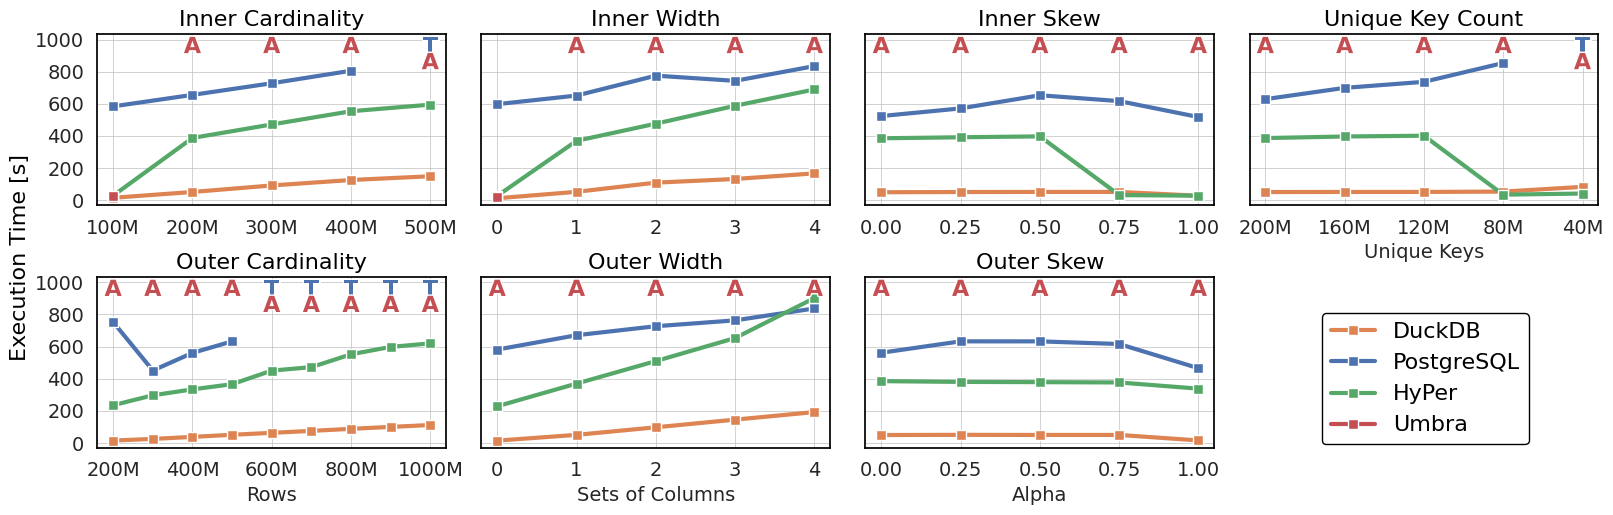

In [45]:
f = plt.figure(figsize=(16, 5.25), dpi=100)

fontsize = 16
tickfontsize = 14

modified_style = copy.copy(my_style)
modified_style['xtick.major.bottom'] = True
modified_style['axes.labelsize'] = tickfontsize
modified_style['ytick.labelsize'] = tickfontsize
modified_style['xtick.labelsize'] = tickfontsize
modified_style['grid.linewidth'] = 0.5
modified_style['ytick.major.left'] = False
modified_style['axes.titlesize'] = fontsize

plot_df = con.execute(f"""
    SELECT pretty_system(system) AS "System",
           pretty_parameter(parameter) AS "Parameter",
           value::DOUBLE AS "Value",
           t AS "Execution Time [s]",
    FROM results_df
    WHERE experiment = 'join'
    AND t > 0
    ORDER BY system_order(pretty_system(system)), "Parameter", "Value"
""").fetchdf()

p = (
    so.Plot(
        plot_df,
        x='Value', y='Execution Time [s]', color='System'
    )
    .facet(
        col='Parameter',
        order=['Inner Cardinality', 'Inner Width', 'Inner Skew', 'Unique Key Count', 'Outer Cardinality', 'Outer Width', 'Outer Skew'],
        wrap=4
    ).add(so.Line(linewidth=3, marker='s', pointsize=7, edgecolor='w'))
    .share(x=False, y=True)
    .scale(color=colors, hue_order=system_order)
    .theme(modified_style)
    .on(f)
    .plot()
)

for ax in f.axes:
    ax.set_ylabel('')
    ylim = ax.get_ylim()
    ax.set_ylim((ylim[0], 1000-ylim[0]))

y1 = 1015
y2 = 915

ax = f.axes[0]
ax.xaxis.set_major_formatter(millions)
ax.set_xlabel('Rows')
dead(ax, 500e6, y1, 'T', colors["PostgreSQL"])
for x in [100e6 * i for i in range(2, 5)]:
    dead(ax, x, y1, 'A', colors["Umbra"])
dead(ax, 500e6, y2, 'A', colors["Umbra"])

ax = f.axes[1]
ax.set_xlabel('Sets of Columns')
for x in [i for i in range(1, 5)]:
    dead(ax, x, y1, 'A', colors["Umbra"])

ax = f.axes[2]
ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Alpha')
for x in [0.0, 0.25, 0.5, 0.75, 1.0]:
    dead(ax, x, y1, 'A', colors["Umbra"])

ax = f.axes[3]
ax.set_xticks([40e6, 80e6, 120e6, 160e6, 200e6])
ax.xaxis.set_major_formatter(millions)
ax.invert_xaxis()
ax.set_xlabel('Unique Keys')
for x in [200e6, 160e6, 120e6, 80e6]:
    dead(ax, x, y1, 'A', colors["Umbra"])
dead(ax, 40e6, y1, 'T', colors["PostgreSQL"])
dead(ax, 40e6, y2, 'A', colors["Umbra"])

ax = f.axes[4]
ax.xaxis.set_major_formatter(millions)
ax.set_xlabel('Rows')
for x in [100e6 * i for i in range(6, 11)]:
    dead(ax, x, y1, 'T', colors["PostgreSQL"])
for x in [100e6 * i for i in range(2, 6)]:
    dead(ax, x, y1, 'A', colors["Umbra"])
for x in [100e6 * i for i in range(6, 11)]:
    dead(ax, x, y2, 'A', colors["Umbra"])

ax = f.axes[5]
ax.set_xlabel('Sets of Columns')
for x in [i for i in range(5)]:
    dead(ax, x, y1, 'A', colors["Umbra"])

ax = f.axes[6]
ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_xlabel('Alpha')
for x in [0.0, 0.25, 0.5, 0.75, 1.0]:
    dead(ax, x, y1, 'A', colors["Umbra"])

f.text(0, 0.5, 'Execution Time [s]', rotation=90, horizontalalignment='center', verticalalignment='center', fontsize=fontsize)

legend = f.legends.pop(0)
f.legend(legend.legend_handles, [t.get_text() for t in legend.texts], bbox_to_anchor=(0.95, 0.415), framealpha=1, edgecolor='black', fontsize=fontsize)

f.subplots_adjust(hspace=0, wspace=0)
f.tight_layout()
f.savefig(f"../figures/join.eps", bbox_inches='tight')
# plt.close(f)

In [46]:
policy_colors = {
    "WeightedCost": deep[1],
    "UnweightedCost": deep[0],
    "Equality": deep[2],
    "Equity": deep[3],
}
policy_order = ['WeightedCost', 'UnweightedCost', 'Equality', 'Equity']

In [47]:
baseline_df = con.execute("""
SELECT 'pipeline' as experiment, 'scenario' as parameter, '[' || value || ']' as value, t
FROM results_df
WHERE system = 'duckdb'
  AND experiment = 'join'
  AND parameter = 'build_row_count'
  AND value = '400000000'
""").fetchdf()
baseline_df.head()

,experiment,parameter,value,t
0,pipeline,scenario,[400000000],125.887297


In [48]:
con.execute("""
CREATE OR REPLACE MACRO pretty_policy(s) AS
CASE s
WHEN 'weightedcost' THEN 'WeightedCost'
WHEN 'unweightedcost' THEN 'UnweightedCost'
WHEN 'equality' THEN 'Equality'
WHEN 'equity' THEN 'Equity'
ELSE s END
""")

con.execute("""
CREATE OR REPLACE MACRO pretty_pipeline_parameter(s) AS
's' || list_aggr([CASE WHEN x % 10_000_000 = 0 THEN CAST(x // 10_000_000 AS VARCHAR) ELSE printf('%.1f', x / 10_000_000) END for x in s::ubigint[]], 'string_agg', '/');
""")

con.execute("""
CREATE OR REPLACE MACRO policy_order(s) AS 
CASE s
WHEN 'WeightedCost' THEN 0
WHEN 'UnweightedCost' THEN 1
WHEN 'Equality' THEN 2
WHEN 'Equity' THEN 3
ELSE 99 END
""")

policies = ["weightedcost", "unweightedcost", "equality", "equity"]

for policy in policies:
    con.execute(f"""ATTACH IF NOT EXISTS '../results/{policy}.duckdb' AS {policy} (READ_ONLY TRUE);""")
con.execute(f"""CREATE OR REPLACE VIEW all_results_1 AS ({' UNION ALL '.join([f"SELECT '{policy}' AS policy, * FROM {policy}.main.results" for policy in policies])})""")

# baseline
con.execute(f"""CREATE OR REPLACE VIEW all_results_2 AS (SELECT * FROM all_results_1) UNION ALL ({' UNION ALL '.join([f"SELECT '{policy}' as policy, * FROM baseline_df" for policy in policies])})""")

pipeline_df = con.execute("""
SELECT * REPLACE (min(t) AS t)
FROM all_results_2
GROUP BY ALL
ORDER BY ALL""").fetchdf()
pipeline_df.head()

,policy,experiment,parameter,value,t
0,equality,pipeline,scenario,"[100000000, 100000000, 100000000, 100000000]",688.421964
1,equality,pipeline,scenario,"[200000000, 100000000, 100000000]",389.909034
2,equality,pipeline,scenario,"[200000000, 100000000, 50000000, 50000000]",518.300021
3,equality,pipeline,scenario,"[200000000, 200000000]",257.486148
4,equality,pipeline,scenario,"[200000000, 50000000, 50000000, 50000000, 5000...",-2.000000


In [49]:
scenario_order = [
    's40',
    's20/20',
    's10/10/10/10',
    
    's30/10',
    's30/5/5',
    's30/5/2.5/2.5',
    # 's30/2.5/2.5/2.5/2.5',

    's20/10/10',
    's20/10/5/5',
    's20/5/5/5/5',
]

macro_def = f"""
CREATE OR REPLACE MACRO scenario_order(s) AS 
CASE s
{'\n'.join([f"WHEN '{s}' THEN {i}" for i, s in enumerate(scenario_order)])}
ELSE 99 END;
"""
con.execute(macro_def)
print(macro_def)


CREATE OR REPLACE MACRO scenario_order(s) AS 
CASE s
WHEN 's40' THEN 0
WHEN 's20/20' THEN 1
WHEN 's10/10/10/10' THEN 2
WHEN 's30/10' THEN 3
WHEN 's30/5/5' THEN 4
WHEN 's30/5/2.5/2.5' THEN 5
WHEN 's20/10/10' THEN 6
WHEN 's20/10/5/5' THEN 7
WHEN 's20/5/5/5/5' THEN 8
ELSE 99 END;



/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_11165/3318955005.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels() , fontsize=tickfontsize)
/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_11165/3318955005.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels() , fontsize=tickfontsize)


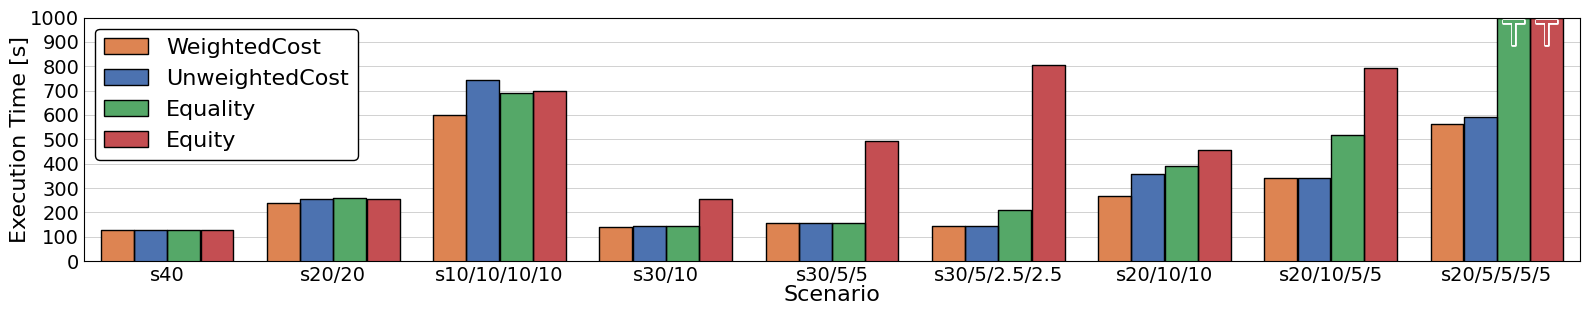

In [57]:
f, ax = plt.subplots(figsize=(16, 3.25), dpi=100, ncols=1, gridspec_kw={"width_ratios": [1]})
ax.set_ylim((0, 1000))
# f = plt.figure(figsize=(16, 3), dpi=100)

fontsize = 16
tickfontsize = 14

modified_style = copy.copy(my_style)
modified_style['axes.labelsize'] = fontsize
modified_style['ytick.labelsize'] = tickfontsize
modified_style['grid.linewidth'] = 0.5
modified_style['xtick.major.bottom'] = False

pipeline_plot_df = con.execute(f"""
    SELECT pretty_policy(policy) AS "Policy",
           pretty_pipeline_parameter(value) AS "Scenario",
           CASE WHEN t < 0 THEN 1000 ELSE t END AS "Execution Time [s]",
    FROM pipeline_df
    WHERE experiment = 'pipeline'
    AND pretty_pipeline_parameter(value) in {scenario_order}
    ORDER BY policy_order(pretty_policy(policy)), scenario_order(pretty_pipeline_parameter(value))
""").fetchdf()

p = (
    so.Plot(
        pipeline_plot_df,
        x='Scenario', y='Execution Time [s]', color='Policy'
    )
    .add(so.Bar(alpha=1), so.Dodge(gap=0.01))
    .scale(color=policy_colors, hue_order=policy_order)
    # .scale(color=colors, hue_order=system_order)
    .theme(modified_style)
    .on(ax)
    .plot()
)

# ax = f.gca()
ax.tick_params(axis='x', which='major')
ax.tick_params(axis='both', which='both', length=0)
ax.set_xticklabels(ax.get_xticklabels() , fontsize=tickfontsize)
ax.set_yticklabels(ax.get_yticklabels() , fontsize=tickfontsize)
ax.set_xlim(ax.get_xlim())
ax.set_axisbelow(True)
ax.yaxis.labelpad = 0
ax.xaxis.labelpad = 0

ax.set_xlabel(ax.get_xlabel(), fontsize=fontsize)
ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize)

yticklabels = [i * 100 for i in range(11)]
ax.set_yticks(yticklabels)
ax.set_yticklabels(yticklabels , fontsize=tickfontsize)

timeouts = [26, 35]

ax.grid(True, alpha=1.0, color='0.75', axis='y', lw=0.5)
for i, bar in enumerate(ax.patches):
    x, y, width, height = bar.get_x(), bar.get_y(), bar.get_width(), bar.get_height()

    if i in timeouts:
        txt = ax.text(x + width / 2, height - 5, 'T', horizontalalignment='center', verticalalignment='top', color=bar.get_facecolor(), fontsize=24)
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
    
    # Manually draw the edges
    ax.plot([x, x, x + width, x + width], [y, y + height, y + height, y], color='black', lw=1)

# axes[1].axis('off')

legend = f.legends.pop(0)
for handle in legend.legend_handles:
    handle.set_edgecolor('black')
    handle.set_lw(1)
ax.legend(legend.legend_handles, [t.get_text() for t in legend.texts], framealpha=1, loc='upper left', edgecolor='black', fontsize=fontsize, ncol=1)

f.subplots_adjust(hspace=0, wspace=0)
f.tight_layout()
f.savefig(f"../figures/pipeline.eps", bbox_inches='tight')
# plt.close(f)

In [107]:
pipeline_plot_df

,Policy,Scenario,Execution Time [s]
0,WeightedCost,s40,125.887297
1,WeightedCost,s20/20,240.274137
2,WeightedCost,s10/10/10/10,601.702705
3,WeightedCost,s30/10,141.305308
4,WeightedCost,s30/5/5,156.531206
5,WeightedCost,s30/5/2.5/2.5,144.248347
6,WeightedCost,s20/10/10,267.306637
7,WeightedCost,s20/10/5/5,339.802005
8,WeightedCost,s20/5/5/5/5,561.398368
9,UnweightedCost,s40,125.887297
